In [3]:
'''
load image of choice
load pix2pix model
GUI for adjusting lamps and windows
GUI for adjusting color
'''

'\nload image of choice\nload pix2pix model\nGUI for adjusting lamps and windows\nGUI for adjusting color\n'

In [4]:
import os, sys, inspect

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

from options.test_options import TestOptions
from data.data_loader import CreateDataLoader
from models.models import create_model

from importlib import reload
from pbw_utils import zdataset, show, labwidget, paintwidget, renormalize, nethook, imgviz, pbar
from PIL import Image
import numpy as np

In [22]:
import numpy as np
import torch

In [5]:
#load model
cmd = ('--name windows_lamps_modulation '
       '--netG modulated --no_instance ' 
       '--input_nc 3 ' 
       '--label_nc 0 ' 
       '--dataroot /datasets/lsun_bedrooms/ ' 
       '--which_epoch 300 ' 
       '--n_stylechannels 2 ').split()
# cmd = {'--name': 'windows_lamps_modulation',
#        '--netG modulated': 'no_instance' ,
#        '--input_nc': 3,
#        '--label_nc': 0,
#        '--dataroot': 'datasets/lsun_bedrooms/', 
#        '--which_epoch': 'latest',
#        '--n_stylechannels':2 }

opt = TestOptions().parse(save=False, cmd=cmd)
model = create_model(opt)

------------ Options -------------
aspect_ratio: 1.0
batchSize: 1
checkpoints_dir: ./checkpoints
cluster_path: features_clustered_010.npy
data_type: 32
dataroot: /datasets/lsun_bedrooms/
debug: False
display_winsize: 512
engine: None
export_onnx: None
feat_num: 3
fineSize: 512
fp16: False
generated: False
gpu_ids: [0]
how_many: 50
input_nc: 3
instance_feat: False
isTrain: False
label_feat: False
label_nc: 0
loadSize: 1024
load_features: False
local_rank: 0
max_dataset_size: inf
model: pix2pixHD
nThreads: 2
n_blocks_global: 9
n_blocks_local: 3
n_clusters: 10
n_downsample_E: 4
n_downsample_global: 4
n_local_enhancers: 1
n_stylechannels: 2
name: windows_lamps_modulation
nef: 16
netG: modulated
ngf: 64
niter_fix_global: 0
no_flip: False
no_instance: True
norm: instance
ntest: inf
onnx: None
output_nc: 3
phase: test
resize_or_crop: scale_width
results_dir: ./results/
serial_batches: False
tf_log: False
use_dropout: False
use_encoded_image: False
verbose: False
which_epoch: 300
-------------


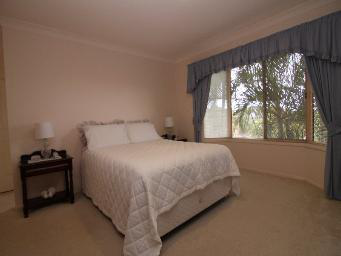

In [32]:
#load image
import torchvision.transforms as transforms
from data.base_dataset import __scale_width
transforms = transforms.Compose([transforms.Lambda(lambda img: __scale_width(img, opt.loadSize)), 
              transforms.ToTensor(),
              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

img_path = 'datasets/lsun_bedrooms/test_A/00000089629ce3ba87bae003073896ba01988dee.webp'
image = Image.open(img_path)
show(image)
baseline = transforms(image.convert('RGB'))



In [55]:
#widget for controlling lamps and windows

reload(labwidget)
lamp = labwidget.Range()
window = labwidget.Range()
im = labwidget.Image()
#lamp_color = labwidget.ColorPicker('#ffffff', desc='lamp light color: ')
window_color = labwidget.ColorPicker('#ffffff', desc='light color: ')

# #num.value = image_number
# lay.value = 'layer8'
# uni.value = 397

#show([['lamp intensity', lamp, '', 'window intensity', window, im]])
#show([['lamp intensity', lamp, lamp_color, 'window intensity', window, window_color, im]])
show([['lamp intensity', lamp, 'window intensity', window, window_color, im]])

#change to forward pass of pix2pix
#self.units = [265, 397] [lamp, window]
#amount is a list 
def get_lit_scene(image, frac):
    generated = model.inference(image.unsqueeze(0), None, None, amount=frac)
    return generated

#baseline = get_lit_scene(image, [-1.0, -1.0], lay.value, uni.value)
im.render(renormalize.as_image(baseline))

def readcolor():
    try:
        floatcolor = [float(int(window_color.value[i:i+2], 16))/255.0  for i in [1,3,5]]
        color = torch.tensor(floatcolor).float()
        #print('color', color)
        if len(color) == 3:
            return color
    except:
        pass
    return torch.tensor([1.0, 1.0, 1.0]).float()

def newimage():
    def norm_value(vals): 
        return np.array([(float(val) * 2 - 100) / 100.0 for val in vals])
    
    frac = norm_value([lamp.value, window.value])
    lit = get_lit_scene(baseline, frac).cpu()

    light = lit - baseline
    color = readcolor()[:,None,None]
    colored = baseline + (light * color)
    im.render(renormalize.as_image(colored[0]))

lamp.on('value', newimage)
window.on('value', newimage)
#lamp_color.on('value', newimage)
window_color.on('value', newimage)
None